# Import libraries

In [101]:
# Standard Libraries
import itertools
from datetime import datetime, timedelta
import re
import string
import warnings

# Suppressing Warnings
warnings.filterwarnings('ignore')

# Numerical and Data Manipulation Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib import ticker

# Plotting options - light blue & light green colors
color = ['#a6cee3', '#b2df8a']
pd.set_option('display.max_colwidth', None)
plt.rcParams["figure.figsize"] = (9, 6)

# Statistical and Time Series Analysis Libraries
import statsmodels.api as sm
from statsmodels.api import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Machine Learning Libraries
from sklearn.model_selection import ParameterGrid, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

# Prophet for Time Series Forecasting
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly

# XGBoost for Machine Learning
import xgboost as xgb
from xgboost import plot_importance, plot_tree

# Pandas Plotting
from pandas.plotting import lag_plot

# Utils 
# from ts_utils import load_and_clean_air_traffic, lag_plots, decompose_series, perform_adf_test, perform_kpss_test

In [2]:
# east_cleaned_pd = pd.read_csv(
#     '../data/east_england_data_revised_cleaned.csv',
#     parse_dates=['count_date', 'timestamp']
# )

# # Ensure the correct data types for columns
# east_cleaned_pd['Month'] = east_cleaned_pd['Month'].astype(int)
# east_cleaned_pd['Day'] = east_cleaned_pd['Day'].astype(int)
# east_cleaned_pd['hour'] = east_cleaned_pd['hour'].astype(int)
# east_cleaned_pd['latitude'] = east_cleaned_pd['latitude'].astype(float)
# east_cleaned_pd['longitude'] = east_cleaned_pd['longitude'].astype(float)


In [103]:
uk_regions = pd.read_csv(
    '../data/pd_raw_count_revised_cleaned.csv',
    parse_dates=['count_date', 'timestamp']
)


In [106]:
# Ensure the correct data types for columns
uk_regions['Month'] = uk_regions['Month'].astype(int)
uk_regions['Day'] = uk_regions['Day'].astype(int)
uk_regions['hour'] = uk_regions['hour'].astype(int)
uk_regions['latitude'] = uk_regions['latitude'].astype(float)
uk_regions['longitude'] = uk_regions['longitude'].astype(float)

In [107]:
print(uk_regions.dtypes)

count_point_id                   int64
direction_of_travel             object
count_date              datetime64[ns]
hour                             int64
region_name                     object
local_authority_name            object
road_type                       object
latitude                       float64
longitude                      float64
all_motor_vehicles             float64
Month                            int64
Day_of_Week                     object
Day                              int64
timestamp               datetime64[ns]
dtype: object


In [108]:
uk_regions.head()

,count_point_id,direction_of_travel,count_date,hour,region_name,local_authority_name,road_type,latitude,longitude,all_motor_vehicles,Month,Day_of_Week,Day,timestamp
0,51,N,2004-05-21,7,South West,Isles of Scilly,Major,49.915023,-6.317073,19.0,5,Friday,21,2004-05-21 07:00:00
1,51,N,2004-05-21,8,South West,Isles of Scilly,Major,49.915023,-6.317073,44.0,5,Friday,21,2004-05-21 08:00:00
2,51,N,2004-05-21,9,South West,Isles of Scilly,Major,49.915023,-6.317073,45.0,5,Friday,21,2004-05-21 09:00:00
3,51,N,2004-05-21,10,South West,Isles of Scilly,Major,49.915023,-6.317073,41.0,5,Friday,21,2004-05-21 10:00:00
4,51,N,2004-05-21,11,South West,Isles of Scilly,Major,49.915023,-6.317073,41.0,5,Friday,21,2004-05-21 11:00:00


In [109]:
uk_regions.shape

(4960860, 14)

In [110]:
uk_regions.isnull().sum()

count_point_id           0
direction_of_travel      0
count_date               0
hour                     0
region_name              0
local_authority_name     0
road_type                0
latitude                 0
longitude                0
all_motor_vehicles      15
Month                    0
Day_of_Week              0
Day                      0
timestamp                0
dtype: int64

In [113]:
uk_regions.dropna(inplace=True)

In [114]:
uk_regions.duplicated().sum()

0

In [116]:
uk_regions.isnull().sum()

count_point_id          0
direction_of_travel     0
count_date              0
hour                    0
region_name             0
local_authority_name    0
road_type               0
latitude                0
longitude               0
all_motor_vehicles      0
Month                   0
Day_of_Week             0
Day                     0
timestamp               0
dtype: int64

In [117]:
uk_regions.shape

(4960845, 14)

In [119]:
# Summary statistics
uk_regions.describe()

,count_point_id,count_date,hour,latitude,longitude,all_motor_vehicles,Month,Day,timestamp
count,4.960845e+06,4960845,4.960845e+06,4.960845e+06,4.960845e+06,4.960845e+06,4.960845e+06,4.960845e+06,4960845
mean,5.224380e+05,2011-08-12 18:53:45.049120768,1.249999e+01,5.261546e+01,-1.538817e+00,5.472543e+02,6.582965e+00,1.553814e+01,2011-08-13 07:23:45.005216512
min,5.100000e+01,2000-03-17 00:00:00,0.000000e+00,4.991224e+01,-7.443134e+00,0.000000e+00,3.000000e+00,1.000000e+00,2000-03-17 07:00:00
25%,4.645800e+04,2006-03-27 00:00:00,9.000000e+00,5.149360e+01,-2.482212e+00,5.200000e+01,5.000000e+00,9.000000e+00,2006-03-27 14:00:00
50%,8.053000e+05,2010-10-04 00:00:00,1.200000e+01,5.238185e+01,-1.511663e+00,2.390000e+02,6.000000e+00,1.600000e+01,2010-10-04 15:00:00
75%,9.444730e+05,2017-10-05 00:00:00,1.500000e+01,5.346918e+01,-3.910483e-01,6.640000e+02,9.000000e+00,2.300000e+01,2017-10-05 14:00:00
max,9.999990e+05,2023-11-07 00:00:00,1.800000e+01,6.076301e+01,1.754553e+00,1.090500e+04,1.100000e+01,3.100000e+01,2023-11-07 18:00:00
std,4.382065e+05,NaN,3.452072e+00,1.467131e+00,1.408841e+00,8.306453e+02,2.238837e+00,8.376718e+00,NaN


## Correlations

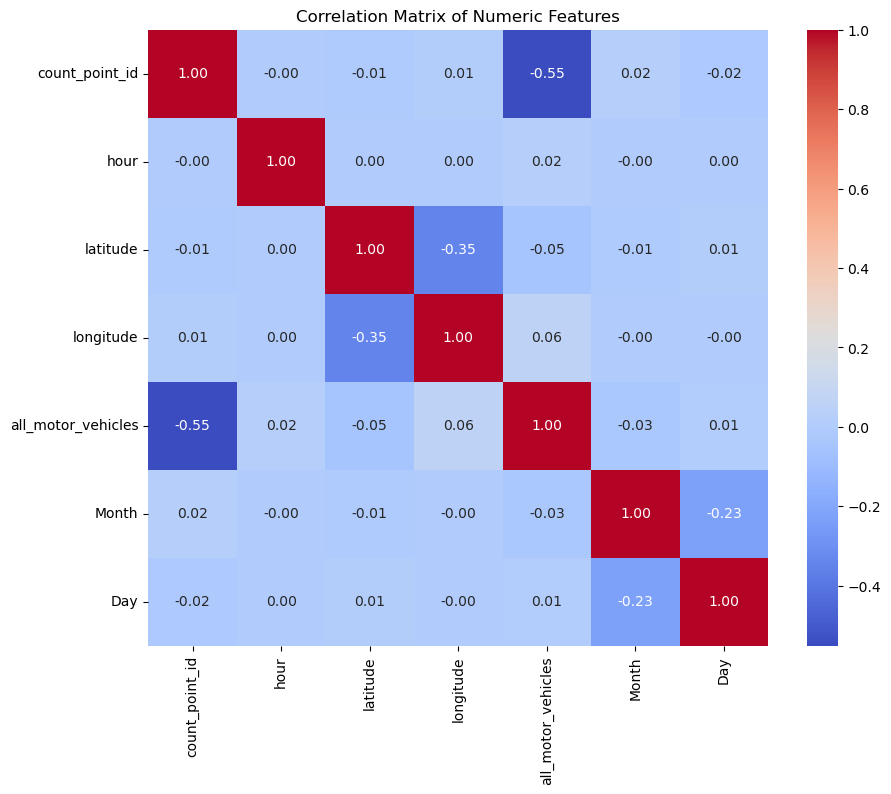

In [120]:
# Select only numeric columns
numeric_columns = uk_regions.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr = numeric_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

**Key Observations:**
- **Strong Negative Correlation**:

    - count_point_id and all_motor_vehicles: The strong negative correlation of -0.61 suggests that as count_point_id increases, the count of all_motor_vehicles decreases. This could be a point to show whether certain count points have fewer vehicles.
- **Positive Correlations:**
    -  latitude and longitude: There is a positive correlation of 0.34. This makes sense geographically, as locations' latitude and longitude within the same region are related.
- **Low or No Correlations:**
    - Many of the features like hour, Month, Day have very low correlations with other variables. For instance, hour shows no significant correlation with any other feature. This suggests that in this dataset, time (as measured by hour) may not play a role in relation to the other features.
- All Motor Vehicles (all_motor_vehicles):
    - Apart from the negative correlation with count_point_id (-0.61), it shows weak negative correlations with latitude (-0.19) and longitude (-0.16), which may be a slight geographic trends in motor vehicle counts. 
    - The correlation with hour (0.08) and Day_of_Week (0.07) is also weak, suggesting that these features may not be as important in predicting motor vehicle counts.


# Exploratory Data Analysis

In [121]:
def format_number(num):
    """
    Formats a large number by converting it into millions, rounding to one decimal place, 
    and removing any unnecessary trailing zeros and decimal points.
    
    Args:
        num (float): The number to be formatted.
    
    Returns:
        str: A string representing the number in millions, rounded to one decimal place.
    """
    return f"{num / 1_000_000:.1f} m".rstrip('0').rstrip('.')

In [122]:
uk_regions.columns

Index(['count_point_id', 'direction_of_travel', 'count_date', 'hour',
       'region_name', 'local_authority_name', 'road_type', 'latitude',
       'longitude', 'all_motor_vehicles', 'Month', 'Day_of_Week', 'Day',
       'timestamp'],
      dtype='object')

### Aggreate the data by latitude and longitude

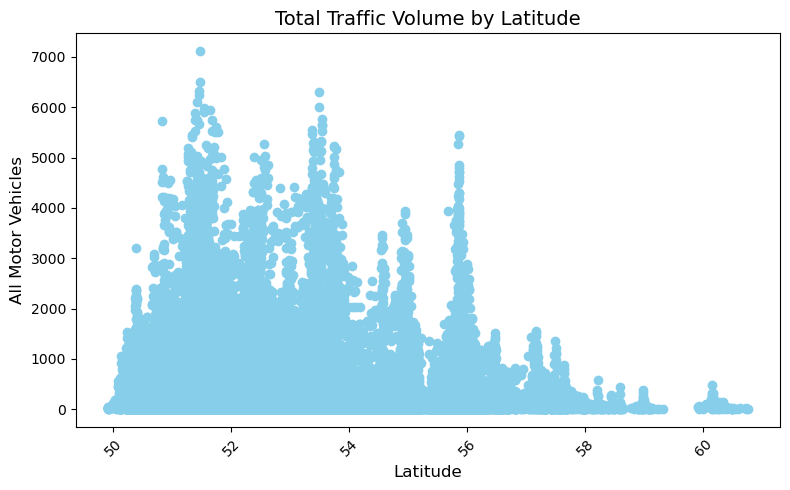

In [123]:
geo_traffic = uk_regions.groupby(['latitude', 'longitude']).agg({
    'all_motor_vehicles': 'mean'
}).reset_index()

### Sort the data by traffic volume
geo_traffic_sorted = geo_traffic.sort_values('all_motor_vehicles', ascending=False)

plt.figure(figsize=(8, 5))
plt.scatter(geo_traffic_sorted['latitude'], geo_traffic_sorted['all_motor_vehicles'], color='skyblue')
plt.title('Total Traffic Volume by Latitude', fontsize=14)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('All Motor Vehicles', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Note** A highest recorded traffic volumes (around 6000 vehicles) occur between latitudes 52 and 53(might likely represent busy regions with major roads or highways in the region).

In [124]:
uk_regions.shape

(4960845, 14)

### Time factors and Road types

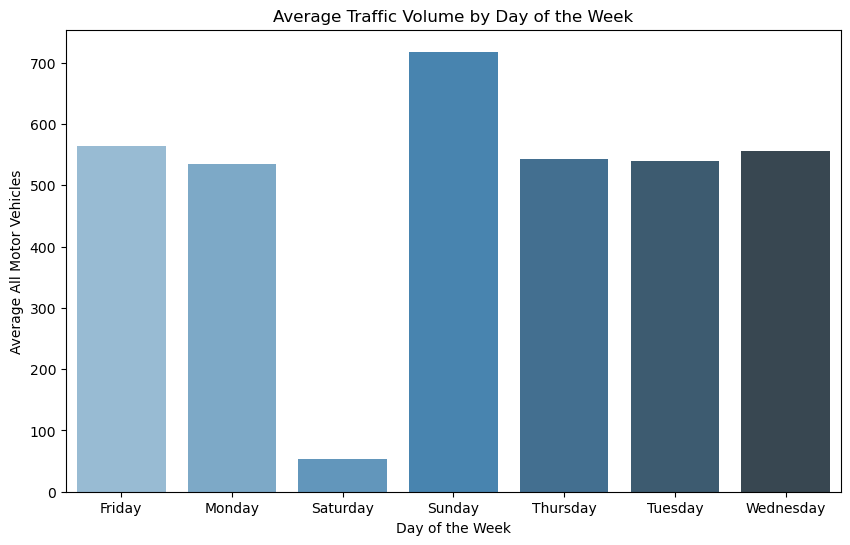

In [125]:
# Grouping data by Day of Week and calculating average traffic volume
traffic_by_day = uk_regions.groupby('Day_of_Week')['all_motor_vehicles'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Day_of_Week', y='all_motor_vehicles', data=traffic_by_day, palette='Blues_d')
plt.title('Average Traffic Volume by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average All Motor Vehicles')
plt.show()

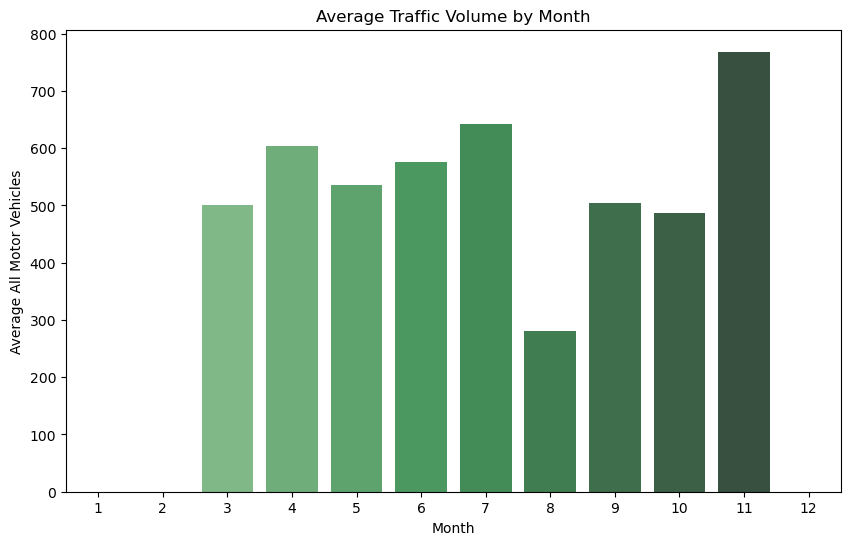

In [126]:
all_months = np.arange(1, 13) # list of all months (1 to 12)

# Grouping data by Month and calculating average traffic volume
avg_traffic_by_month = uk_regions.groupby('Month')['all_motor_vehicles'].mean().reindex(all_months, fill_value=0).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='all_motor_vehicles', data=avg_traffic_by_month, palette='Greens_d')
plt.title('Average Traffic Volume by Month')
plt.xlabel('Month')
plt.ylabel('Average All Motor Vehicles')
plt.show()

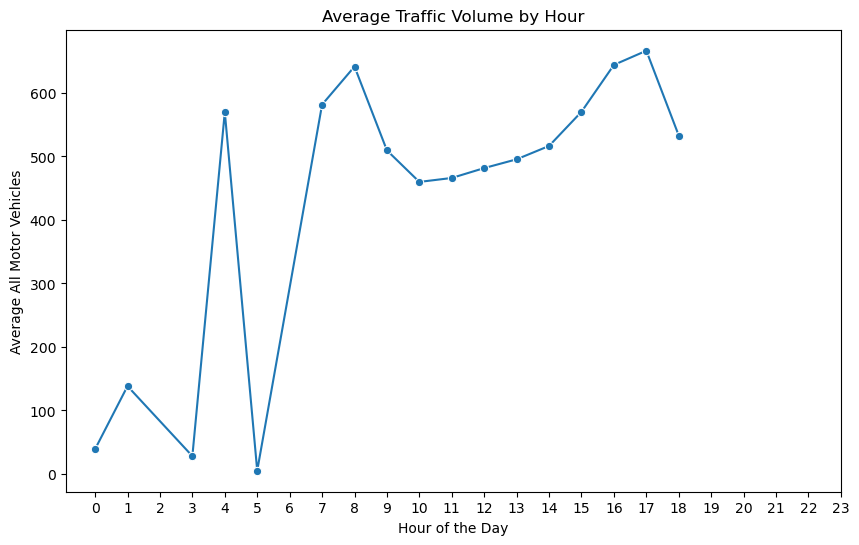

In [127]:
# Grouping data by hour and calculating average traffic volume
traffic_by_hour = uk_regions.groupby('hour')['all_motor_vehicles'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='all_motor_vehicles', data=traffic_by_hour, marker='o')
plt.title('Average Traffic Volume by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average All Motor Vehicles')
plt.xticks(range(0, 24))  # To ensure all hours are shown
plt.show()

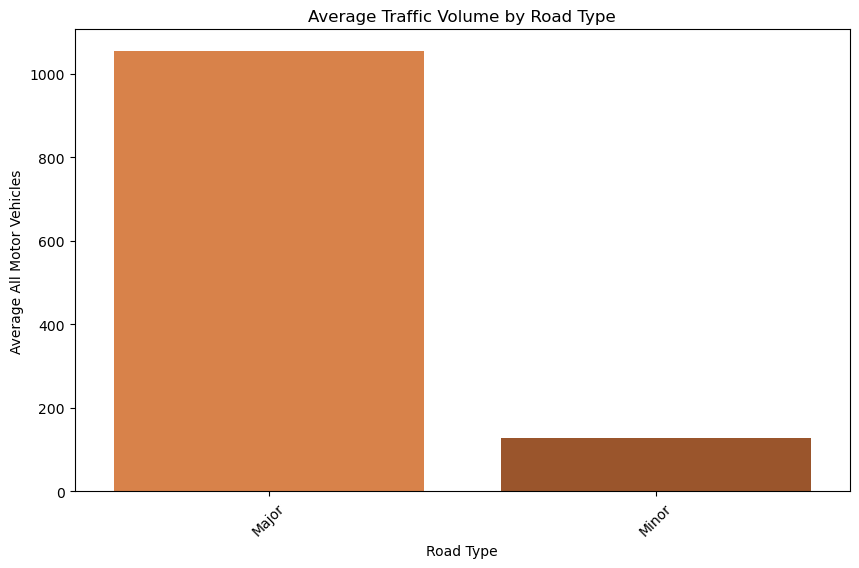

In [128]:

traffic_by_road_type = uk_regions.groupby('road_type')['all_motor_vehicles'].mean().reset_index()

# Plotting the average traffic volume by road type
plt.figure(figsize=(10, 6))
sns.barplot(x='road_type', y='all_motor_vehicles', data=traffic_by_road_type, palette='Oranges_d')
plt.title('Average Traffic Volume by Road Type')
plt.xlabel('Road Type')
plt.ylabel('Average All Motor Vehicles')
plt.xticks(rotation=45) 
plt.show()

**Note** There is a substantial disparity in traffic volume between major and minor roads. It could reflect both the road capacity and the types of vehicles using these roads. Major roads usually handle high-speed, long-distance traffic, while minor roads see local or neighborhood traffic.

### Group by month and day of the week to check for patterns

In [158]:
print(uk_regions[['timestamp', 'count_date', 'hour']].head())

            timestamp count_date  hour
0 2004-05-21 07:00:00 2004-05-21     7
1 2004-05-21 08:00:00 2004-05-21     8
2 2004-05-21 09:00:00 2004-05-21     9
3 2004-05-21 10:00:00 2004-05-21    10
4 2004-05-21 11:00:00 2004-05-21    11


In [159]:
# group by 'timestamp' - this is the hourly data 
hourly_grouped_data = uk_regions.groupby('timestamp').agg({"all_motor_vehicles": sum}).reset_index()
hourly_grouped_data.head()

,timestamp,all_motor_vehicles
0,2000-03-17 07:00:00,116479.0
1,2000-03-17 08:00:00,139183.0
2,2000-03-17 09:00:00,107061.0
3,2000-03-17 10:00:00,96908.0
4,2000-03-17 11:00:00,99507.0


In [160]:
hourly_grouped_data.shape

(32192, 2)

In [161]:
hourly_grouped_data.isna().sum()

timestamp             0
all_motor_vehicles    0
dtype: int64

In [162]:
hourly_grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32192 entries, 0 to 32191
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           32192 non-null  datetime64[ns]
 1   all_motor_vehicles  32192 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 503.1 KB


In [163]:
print(hourly_grouped_data.index)

if not isinstance(hourly_grouped_data.index, pd.DatetimeIndex):
    hourly_grouped_data.set_index('timestamp', inplace=True)
print(hourly_grouped_data.index)

RangeIndex(start=0, stop=32192, step=1)
DatetimeIndex(['2000-03-17 07:00:00', '2000-03-17 08:00:00',
               '2000-03-17 09:00:00', '2000-03-17 10:00:00',
               '2000-03-17 11:00:00', '2000-03-17 12:00:00',
               '2000-03-17 13:00:00', '2000-03-17 14:00:00',
               '2000-03-17 15:00:00', '2000-03-17 16:00:00',
               ...
               '2023-11-07 09:00:00', '2023-11-07 10:00:00',
               '2023-11-07 11:00:00', '2023-11-07 12:00:00',
               '2023-11-07 13:00:00', '2023-11-07 14:00:00',
               '2023-11-07 15:00:00', '2023-11-07 16:00:00',
               '2023-11-07 17:00:00', '2023-11-07 18:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=32192, freq=None)


In [164]:
# hourly range between the first and last timestamps
first_day = hourly_grouped_data.index.min()
last_day = hourly_grouped_data.index.max()

In [165]:
first_day

Timestamp('2000-03-17 07:00:00')

In [166]:
last_day

Timestamp('2023-11-07 18:00:00')

In [167]:
full_index = pd.date_range(start=first_day, end=last_day, freq="H")
full_index

DatetimeIndex(['2000-03-17 07:00:00', '2000-03-17 08:00:00',
               '2000-03-17 09:00:00', '2000-03-17 10:00:00',
               '2000-03-17 11:00:00', '2000-03-17 12:00:00',
               '2000-03-17 13:00:00', '2000-03-17 14:00:00',
               '2000-03-17 15:00:00', '2000-03-17 16:00:00',
               ...
               '2023-11-07 09:00:00', '2023-11-07 10:00:00',
               '2023-11-07 11:00:00', '2023-11-07 12:00:00',
               '2023-11-07 13:00:00', '2023-11-07 14:00:00',
               '2023-11-07 15:00:00', '2023-11-07 16:00:00',
               '2023-11-07 17:00:00', '2023-11-07 18:00:00'],
              dtype='datetime64[ns]', length=207252, freq='H')

In [168]:
# calculate the difference between the full index and the hourly grouped data index
full_index.difference(hourly_grouped_data.index).shape

(175060,)

In [169]:
full_index.isnull().sum()

0

In [170]:
# Reindexing the DataFrame to fill in missing values in hourly_grouped_data to ensure continuous hourly index from start to end
hourly_grouped_data_cleaned = hourly_grouped_data.reindex(full_index)

In [171]:
hourly_grouped_data_cleaned.columns

Index(['all_motor_vehicles'], dtype='object')

In [172]:
hourly_grouped_data_cleaned.shape

(207252, 1)

In [175]:
hourly_grouped_data_cleaned = hourly_grouped_data_cleaned.reset_index()
hourly_grouped_data_cleaned.rename(columns={'index': 'timestamp'}, inplace=True)
print(hourly_grouped_data_cleaned.head())

            timestamp  all_motor_vehicles
0 2000-03-17 07:00:00            116479.0
1 2000-03-17 08:00:00            139183.0
2 2000-03-17 09:00:00            107061.0
3 2000-03-17 10:00:00             96908.0
4 2000-03-17 11:00:00             99507.0


In [176]:
hourly_grouped_data_cleaned.shape

(207252, 2)

In [177]:
hourly_grouped_data_cleaned.head()

,timestamp,all_motor_vehicles
0,2000-03-17 07:00:00,116479.0
1,2000-03-17 08:00:00,139183.0
2,2000-03-17 09:00:00,107061.0
3,2000-03-17 10:00:00,96908.0
4,2000-03-17 11:00:00,99507.0


In [178]:
hourly_grouped_data_cleaned.isna().sum()

timestamp                  0
all_motor_vehicles    175060
dtype: int64

In [37]:
# hourly_grouped_data_cleaned.set_index('timestamp', inplace=True)

In [179]:
hourly_grouped_data_cleaned['all_motor_vehicles'].fillna(method='ffill', inplace=True)

In [180]:
hourly_grouped_data_cleaned.isna().sum()

timestamp             0
all_motor_vehicles    0
dtype: int64

In [181]:
hourly_grouped_data_cleaned.shape

(207252, 2)

In [40]:
# hourly_grouped_data_cleaned.set_index('timestamp', inplace=True)

In [182]:
hourly_grouped_data_cleaned[hourly_grouped_data_cleaned['all_motor_vehicles'] > 0].shape

(207252, 2)

In [183]:
hourly_average_zeros = hourly_grouped_data_cleaned[hourly_grouped_data_cleaned['all_motor_vehicles'] == 0].shape
print(hourly_average_zeros)

(0, 2)


In [184]:
hourly_grouped_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207252 entries, 0 to 207251
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   timestamp           207252 non-null  datetime64[ns]
 1   all_motor_vehicles  207252 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.2 MB


In [186]:
# Ensure the 'timestamp' column is in datetime format
hourly_grouped_data_cleaned['timestamp'] = pd.to_datetime(hourly_grouped_data_cleaned['timestamp'])

# Set 'timestamp' as the index
hourly_grouped_data_cleaned.set_index('timestamp', inplace=True)

In [187]:
# Resample the data to monthly and sum the values
monthly_average_traffic = hourly_grouped_data_cleaned.resample('MS').sum().reset_index()

# Display the first few rows of the resampled DataFrame
print(monthly_average_traffic.head(10))


   timestamp  all_motor_vehicles
0 2000-03-01          39257164.0
1 2000-04-01          82032700.0
2 2000-05-01          89490291.0
3 2000-06-01          89880510.0
4 2000-07-01          96094604.0
5 2000-08-01          98878344.0
6 2000-09-01          33171006.0
7 2000-10-01          71933471.0
8 2000-11-01           5862546.0
9 2000-12-01           3182088.0


In [44]:
# monthly_average_traffic = hourly_grouped_data_cleaned.resample('MS').sum().reset_index()

# # Display the resampled DataFrame
# print(monthly_average_traffic.head(10))

In [188]:
monthly_average_traffic.shape

(285, 2)

In [189]:
monthly_average_traffic.describe()

,timestamp,all_motor_vehicles
count,285,2.850000e+02
mean,2011-12-31 16:10:06.315789568,4.105524e+07
min,2000-03-01 00:00:00,2.678400e+04
25%,2006-02-01 00:00:00,6.315840e+06
50%,2012-01-01 00:00:00,4.403230e+07
75%,2017-12-01 00:00:00,6.370194e+07
max,2023-11-01 00:00:00,1.200384e+08
std,NaN,3.173297e+07


In [190]:
monthly_average_traffic.isna().sum()

timestamp             0
all_motor_vehicles    0
dtype: int64

In [191]:
numeric_description = monthly_average_traffic.describe(include=[np.number])
print(numeric_description)

       all_motor_vehicles
count        2.850000e+02
mean         4.105524e+07
std          3.173297e+07
min          2.678400e+04
25%          6.315840e+06
50%          4.403230e+07
75%          6.370194e+07
max          1.200384e+08


In [192]:
monthly_data = monthly_average_traffic.copy()

In [193]:
monthly_data.shape

(285, 2)

In [194]:
monthly_data.head()

,timestamp,all_motor_vehicles
0,2000-03-01,39257164.0
1,2000-04-01,82032700.0
2,2000-05-01,89490291.0
3,2000-06-01,89880510.0
4,2000-07-01,96094604.0


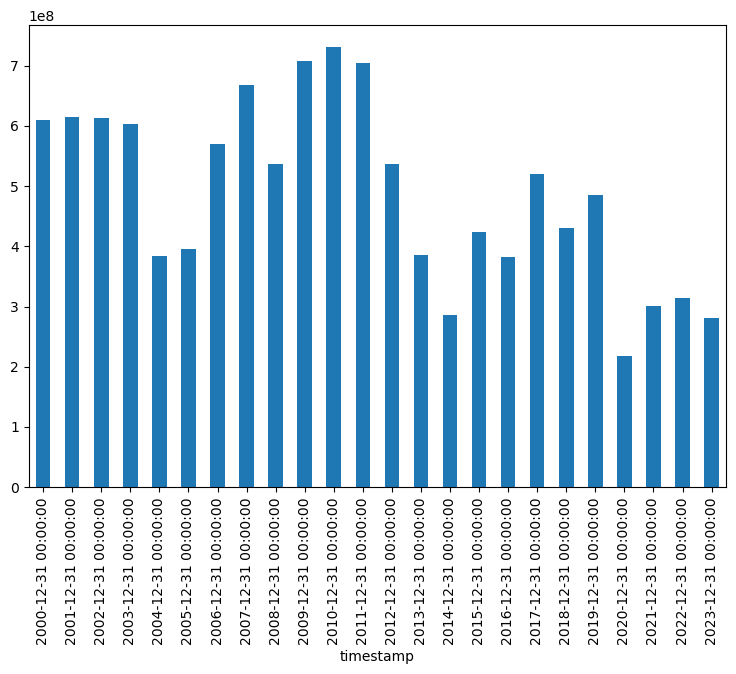

In [195]:
monthly_data.set_index('timestamp', inplace=True)
monthly_data_traffic_yearly = monthly_data.resample('Y').sum()
monthly_data_traffic_yearly['all_motor_vehicles'].plot(kind='bar')
plt.show()

**Interpretation**

- Traffic Growth until 2013-2014: The consistent increase in traffic up to 2014 might reflect growing vehicle usage, infrastructure development, or population increases during that period.

- Post-2014 Decline: The significant drop in traffic from 2015 onward could be due to various factors like changing transport policies, the rise of alternative transport modes, or global events affecting vehicle usage (e.g., oil price fluctuations, economic downturns, etc.).

- Impact of COVID-19 (2020-2021): The sharp decline in traffic in 2020 aligns with the global pandemic, where many countries experienced lockdowns and reduced movement, leading to lower traffic volumes. 

## EDA - Traffic Trends Analysis

In [196]:
def plot_rolling_mean_and_std(series: pd.Series, window: int) -> None:
    """
    This function plots the rolling mean and rolling standard deviation
    of a time series to help visually inspect stationarity.
    
    Args:
        series (pd.Series): Time series data (single column)
        window (int): Window size for rolling calculations (in time units)
        
    Returns: 
        None
    """
    # Get Rolling Mean and STD
    roll_mean = series.rolling(window=window).mean()
    roll_std = series.rolling(window=window).std()

    # Plot original series, rolling mean, and rolling standard deviation
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Original', color='blue', alpha=0.5)
    plt.plot(roll_mean, label=f'Rolling Mean (window={window})', color='red')
    plt.plot(roll_std, label=f'Rolling STD (window={window})', color='green')
    
    # Adding titles and labels
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [93]:
def plot_rolling_mean_and_std(dataframe: pd.DataFrame, window: int) -> None:
    """
    This function plots the dataframes
    rolling mean and rolling standard deviation.
    ---
    Args:
        dataframe (pd.DataFrame): Dataframe contains the timeseries
        window (int): window size
    Returns: None
    """
    df = dataframe.copy()
    # Get Things Rolling
    roll_mean = df.rolling(window=window).mean()
    roll_std = df.rolling(window=window).std()

    # Figure
    fig, ax = plt.subplots(figsize=(16, 9), facecolor='w')
    ax.plot(df, label='Original')
    ax.plot(roll_mean, label='Rolling Mean')
    ax.plot(roll_std,  label='Rolling STD')

    # Legend & Grid
    ax.legend(loc='upper right')
    plt.grid(linestyle=":", color='grey')
    plt.show()

In [197]:
monthly_data.head()

,all_motor_vehicles
timestamp,
2000-03-01,39257164.0
2000-04-01,82032700.0
2000-05-01,89490291.0
2000-06-01,89880510.0
2000-07-01,96094604.0


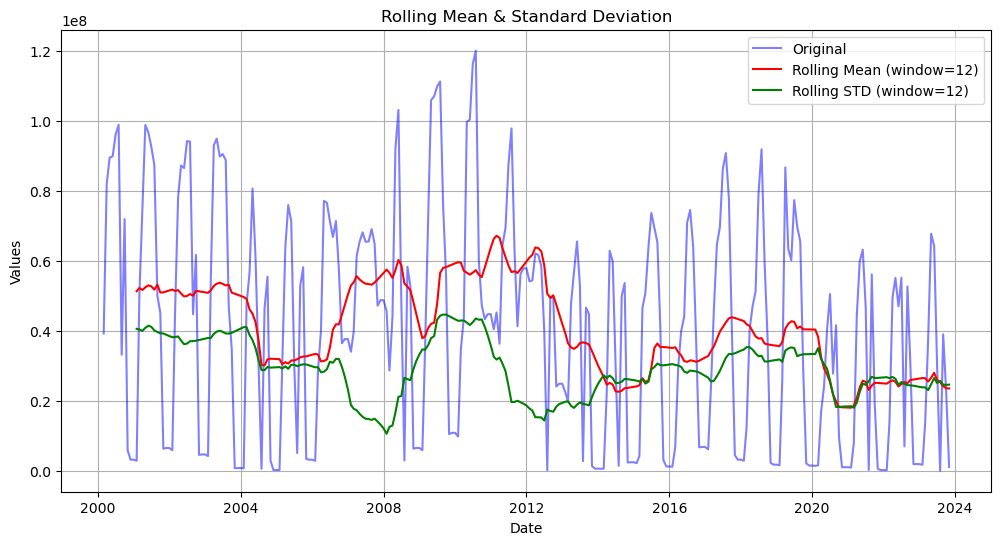

In [198]:

# Plot the rolling mean and standard deviation for a 12-month window 
plot_rolling_mean_and_std(monthly_data['all_motor_vehicles'], window=12) 

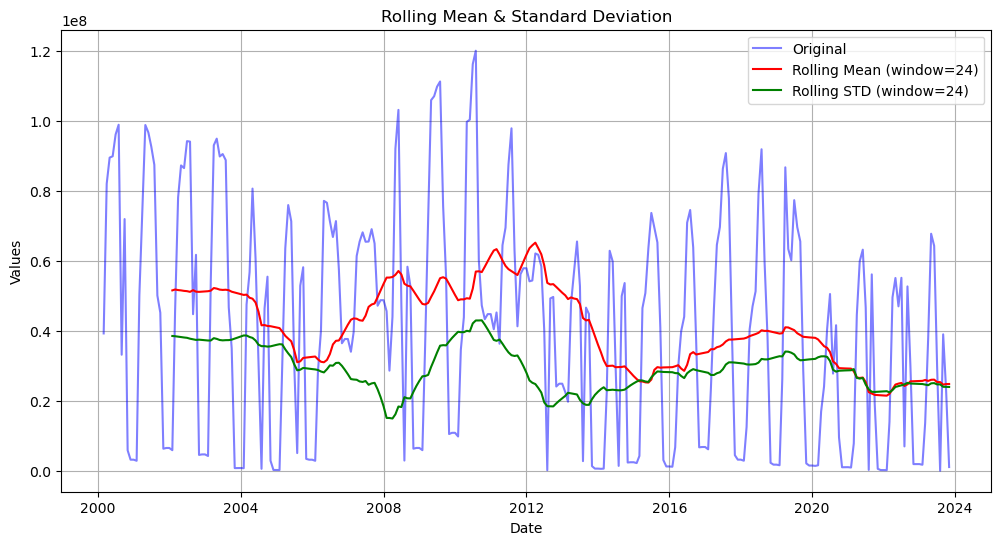

In [199]:
# Plot the rolling mean and standard deviation for a 24-month window 
plot_rolling_mean_and_std(monthly_data['all_motor_vehicles'], window=24)

In [200]:
monthly_data["all_motor_vehicles"].head()

timestamp
2000-03-01    39257164.0
2000-04-01    82032700.0
2000-05-01    89490291.0
2000-06-01    89880510.0
2000-07-01    96094604.0
Name: all_motor_vehicles, dtype: float64

### Seasonalilty and Trends

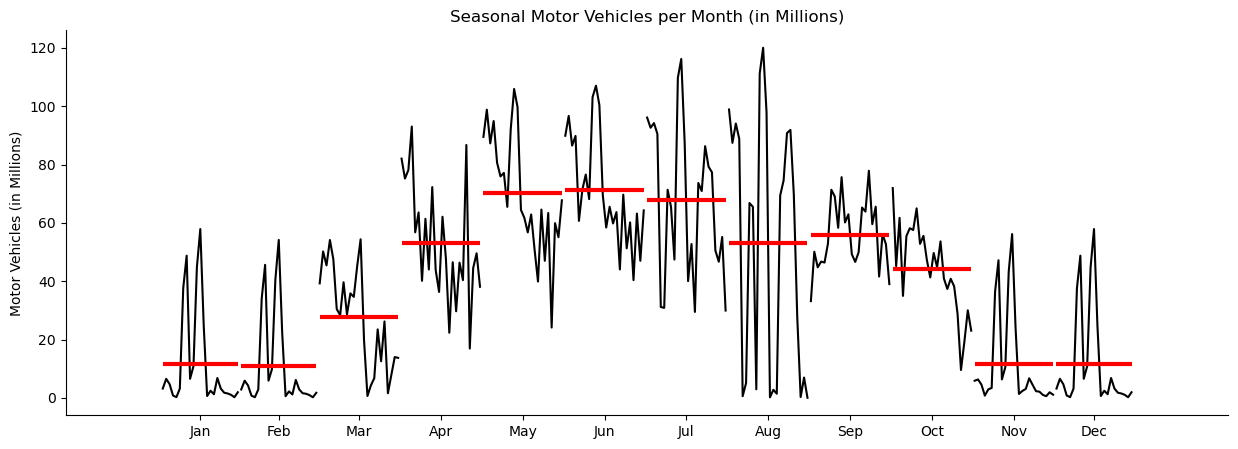

In [204]:
from statsmodels.graphics.tsaplots import month_plot

# Convert the traffic volume to millions for easier understanding
monthly_data['all_motor_vehicles_millions'] = monthly_data['all_motor_vehicles'] / 1e6

# Plot the seasonal motor vehicles per month with the adjusted values
plt.figure(figsize=(15, 5))

# Create the seasonal plot with the modified values
month_plot(monthly_data["all_motor_vehicles_millions"], ax=plt.gca())
plt.title("Seasonal Motor Vehicles per Month (in Millions)")
plt.ylabel("Motor Vehicles (in Millions)") 
sns.despine()
plt.show()


### Dealing with Non-Stationarity

In [218]:
from statsmodels.tsa.stattools import adfuller

def perform_adf_test(series: pd.Series) -> None:
    """
    Perform the Augmented Dickey-Fuller test to check stationarity.
    
    Args:
        series (pd.Series): Time series data
    
    Returns:
        None
    """
    adf_stat, p_value, used_lag, n_obs, crit_vals, icbest = adfuller(series)
    print('Augmented Dickey-Fuller test')
    print('-------------------------------------')
    print(f'ADF Statistic: {adf_stat}')
    print(f'p-value: {p_value}')
    print(f'Number of Lags Used: {used_lag}')
    print(f'Number of Observations: {n_obs}')
    print('Critical Values:')
    for key, value in crit_vals.items():
        print(f'   {key}: {value}')
    print(f'IC Best: {icbest}')

perform_adf_test(monthly_data['all_motor_vehicles'])

Augmented Dickey-Fuller test
-------------------------------------
ADF Statistic: -2.1768105011669543
p-value: 0.2147692902696116
Number of Lags Used: 14
Number of Observations: 270
Critical Values:
   1%: -3.4548039258751206
   5%: -2.872304928618605
   10%: -2.5725063100137175
IC Best: 9651.654125077532


In [213]:
from statsmodels.tsa.stattools import kpss

def perform_kpss_test(series: pd.Series) -> None:
    """
    Kwiatkowski-Phillips-Schmidt-Shin test for stationarity.
    - The null hypothesis for the test is that the data is stationary.
    - If the test statistic is greater than the critical value, we reject the null hypothesis.
    
    Args:
    - series (pd.Series): The time series data to test.
    
    Returns: None
    """
    kpss_stat, p_value, n_lags, crit_vals = kpss(series, nlags='auto', store=False)
    print('Kwiatkowski-Phillips-Schmidt-Shin test')
    print('-------------------------------------')
    print(f'KPSS Statistic: {kpss_stat}')
    print(f'p-value: {p_value}')
    print(f'Number of Lags: {n_lags}')
    print(f'Critical Values: {crit_vals}')

# Use it on the 'all_motor_vehicles' column from monthly_data
perform_kpss_test(monthly_data['all_motor_vehicles'])

Kwiatkowski-Phillips-Schmidt-Shin test
-------------------------------------
KPSS Statistic: 0.900864917133861
p-value: 0.01
Number of Lags: 7
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


**Notes**
- Both tests indicate non-stationarity therefore differencing to make the time series stationary.

**Results**
- ADF Test Results: we fail to reject the null hypothesis, which means the time series is non-stationary.
- KPSS Test Results: we fail to reject the null hypothesis, which means the time series is non-stationary.

TODO:
- Apply `differencing` to remove the trend and make the data stationary
- Investigate the impact of differencing on the KPSS test results.
- Investigate the impact of differencing on the ADF test results.


In [222]:
#calculates the difference between consecutive data points in order to find the trend
diff_data = monthly_data['all_motor_vehicles'].diff().dropna()

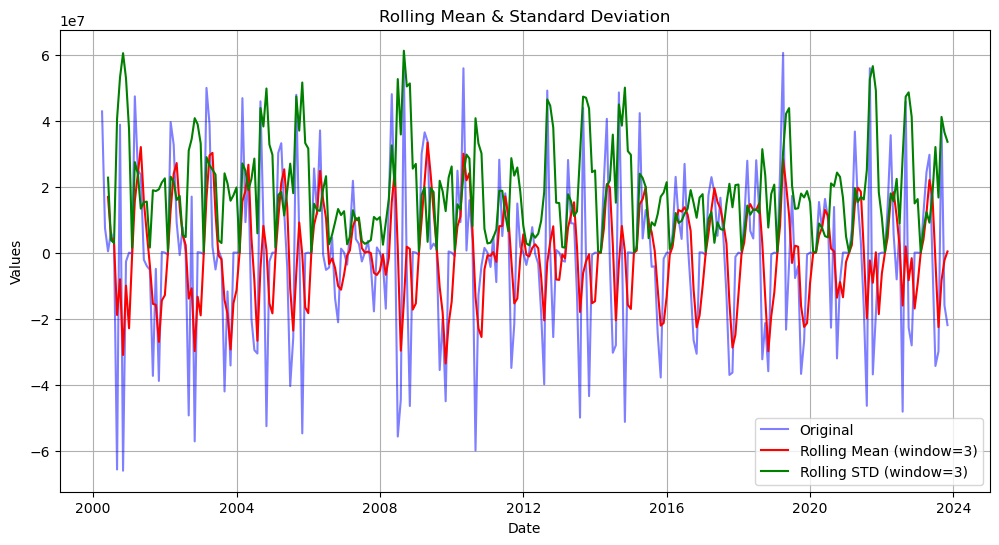

In [223]:
# Plot rolling mean and standard deviation after differencing
plot_rolling_mean_and_std(diff_data, window=3)

In [226]:
# Perform the Augmented Dickey-Fuller test on the differenced data
perform_adf_test(diff_data)

Augmented Dickey-Fuller test
-------------------------------------
ADF Statistic: -6.489622276596727
p-value: 1.2359645009842042e-08
Number of Lags Used: 13
Number of Observations: 270
Critical Values:
   1%: -3.4548039258751206
   5%: -2.872304928618605
   10%: -2.5725063100137175
IC Best: 9619.612009819197


In [227]:
perform_kpss_test(diff_data)

Kwiatkowski-Phillips-Schmidt-Shin test
-------------------------------------
KPSS Statistic: 0.008350696163172754
p-value: 0.1
Number of Lags: 2
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


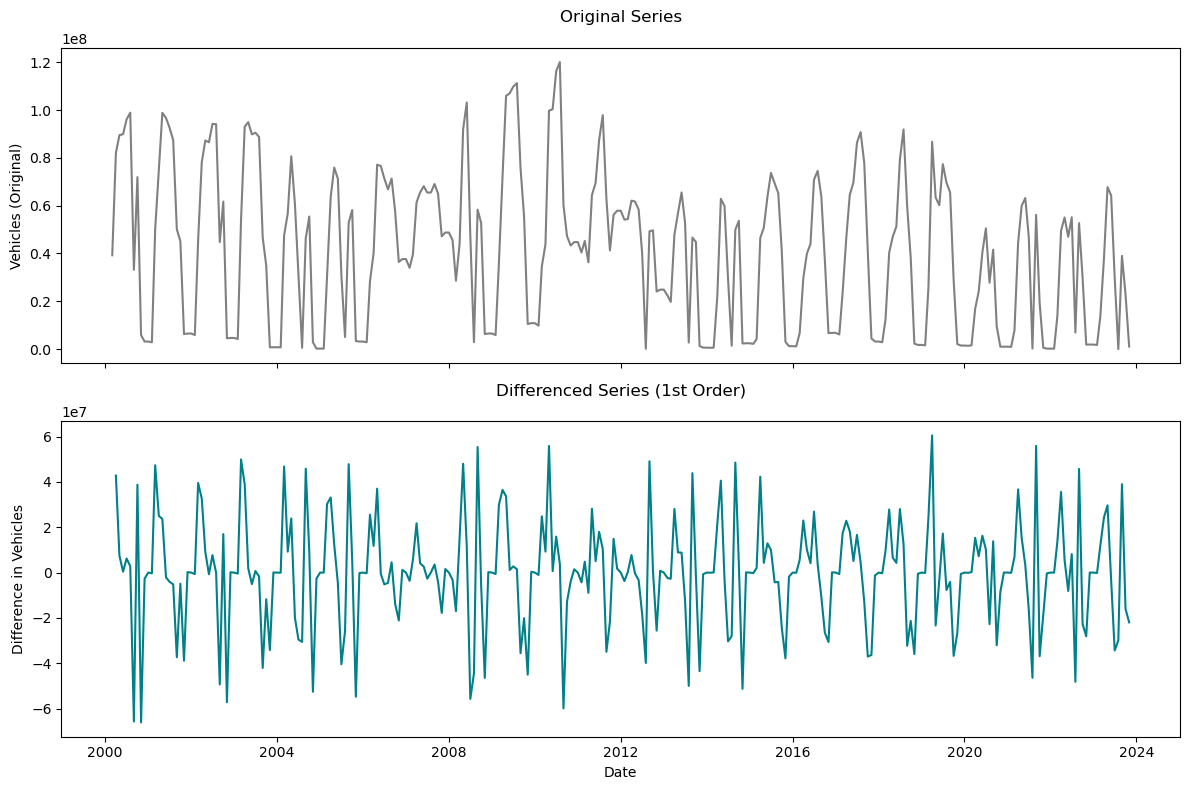

In [228]:
# Create the figure and two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))

# Plot the original data in the first subplot
ax1.plot(monthly_data['all_motor_vehicles'], color='#808080')
ax1.set_ylabel('Vehicles (Original)')
ax1.set_title('Original Series\n')

# Plot the differenced data in the second subplot
ax2.plot(diff_data, color='#008088')
ax2.set_xlabel('Date')
ax2.set_ylabel('Difference in Vehicles')
ax2.set_title('Differenced Series (1st Order)\n')
plt.tight_layout()
plt.show()

**Observations**

- We can see see that both tests show that the series is stationary. 
- The low p-value in the ADF test and the high p-value in the KPSS test confirm that the time series no longer has a unit root and is now suitable for further time series modeling

# Autorrelation Analysis

In [229]:
# Plot lag correlations for original series


from pandas.plotting import lag_plot
import matplotlib.pyplot as plt

def lag_plots(series: pd.Series, lags=[1, 12, 24]) -> None:
    """
    This function plots the lag correlation between 
    current y(t) and y(t+1), y(t+12), and y(t+24) lags (default) 
    or any custom lag provided, with customized titles.
    
    Args:
        series (pd.Series): The time series data (single column).
        lags (list): List of lag values for which to create lag plots.
    
    Returns:
        None
    """
    
    # Custom titles for the lags
    titles = ["Correlation with next month", "Correlation with next year", "Correlation with next 2 years"]

    # Number of subplots based on the number of lags
    num_lags = len(lags)
    fig, axes = plt.subplots(1, num_lags, figsize=(16, 9), facecolor='w')
    
    # Loop over the lags to create lag plots for each specified lag
    for i, lag in enumerate(lags):
        lag_plot(series, lag=lag, ax=axes[i], c='#187bcd' if i % 2 == 0 else 'grey')
        
        # Set custom title based on the index of the lag
        axes[i].set_title(titles[i], fontsize=15, pad=10, color='white', backgroundcolor='purple')
        
        # Set x and y axis labels
        axes[i].set_xlabel("y(t)")
        axes[i].set_ylabel(f"y(t+{lag})")
        axes[i].grid(linestyle=":", color='grey')

    plt.tight_layout()
    plt.show()



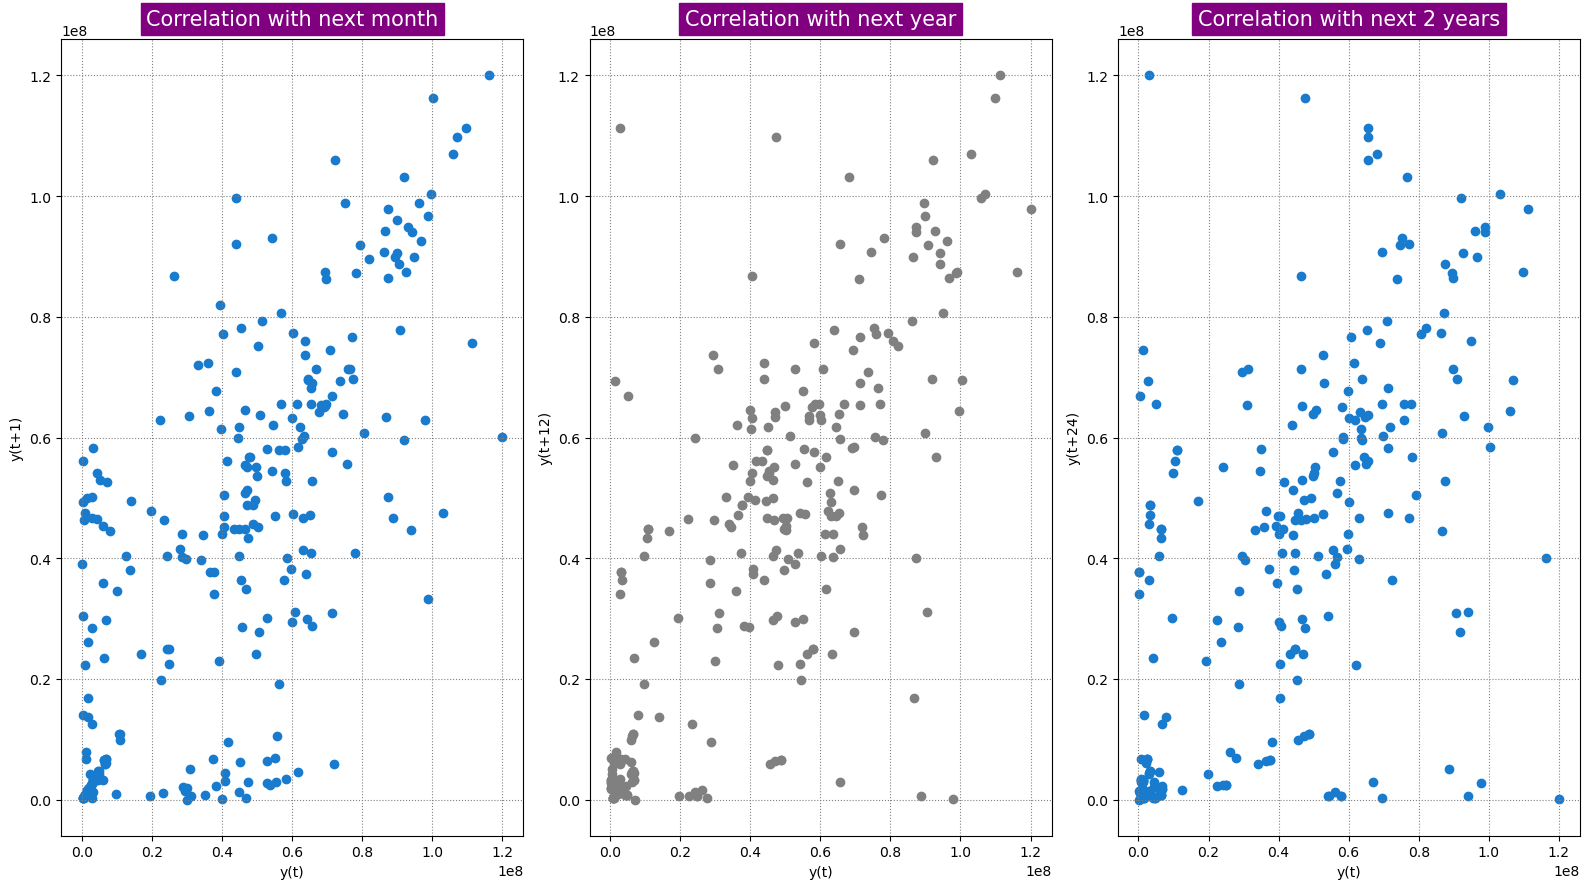

In [230]:
# Plot lag correlations for original series
lag_plots(monthly_data['all_motor_vehicles'], lags=[1, 12, 24])  

**Notes**
- The first month of correlation shows that there is a strong significiant correlation between the number of motor vehicles and the number of pedal cycles. This is expected as motor vehicles are a major contributor to traffic volume.
- As the year progress, we can see that the correlation between the number of motor vehiclesdecreases, meaning that there is less significance as the year go by.


### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

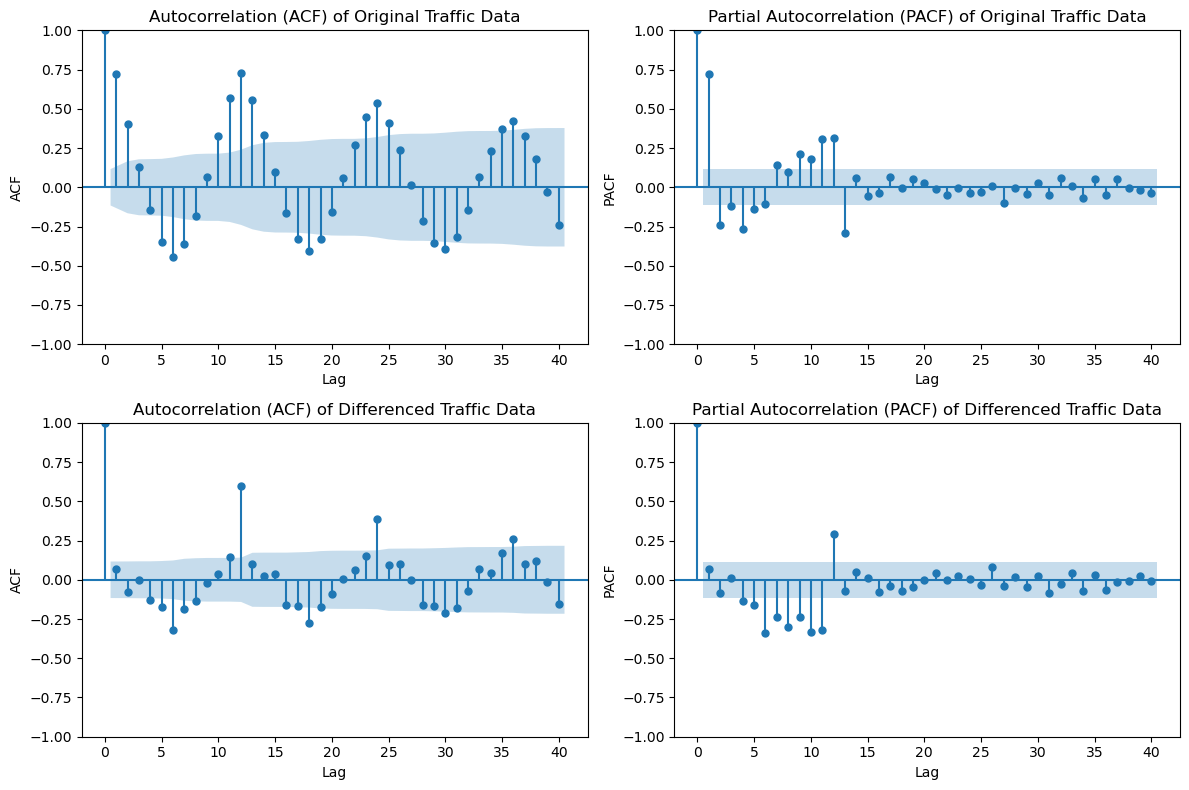

In [231]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Apply first-order differencing to the data
diff_data = monthly_data['all_motor_vehicles'].diff().dropna()

# Create subplots for ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(12, 8))

# Plot the ACF for the original data
plot_acf(monthly_data['all_motor_vehicles'].dropna(), lags=40, ax=ax1[0])
ax1[0].set_title('Autocorrelation (ACF) of Original Traffic Data', fontsize=12)
ax1[0].set_xlabel('Lag', fontsize=10)
ax1[0].set_ylabel('ACF', fontsize=10)

# Plot the PACF for the original data
plot_pacf(monthly_data['all_motor_vehicles'].dropna(), lags=40, ax=ax1[1])
ax1[1].set_title('Partial Autocorrelation (PACF) of Original Traffic Data', fontsize=12)
ax1[1].set_xlabel('Lag', fontsize=10)
ax1[1].set_ylabel('PACF', fontsize=10)

# Plot the ACF for the differenced data
plot_acf(diff_data, lags=40, ax=ax2[0])
ax2[0].set_title('Autocorrelation (ACF) of Differenced Traffic Data', fontsize=12)
ax2[0].set_xlabel('Lag', fontsize=10)
ax2[0].set_ylabel('ACF', fontsize=10)

# Plot the PACF for the differenced data
plot_pacf(diff_data, lags=40, ax=ax2[1])
ax2[1].set_title('Partial Autocorrelation (PACF) of Differenced Traffic Data', fontsize=12)
ax2[1].set_xlabel('Lag', fontsize=10)
ax2[1].set_ylabel('PACF', fontsize=10)

# Display the plots
plt.tight_layout()
plt.show()


# Decomposition

In [232]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_series(series: pd.Series, period: int, title: str) -> None:
    """
    This function decomposes the time series into trend, seasonality, and residuals.
    
    Args:
        series (pd.Series): The time series data to decompose.
        period (int): The number of observations per cycle (e.g., 12 for monthly data).
        title (str): Title for the plot.
    
    Returns:
        None
    """
    # Decomposition
    decomposition = seasonal_decompose(series, model='additive', period=period)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 10), facecolor='w')

    ax1.plot(series, label='Original', color='blue')
    ax1.set_title('Original Series')
    ax1.legend()

    ax2.plot(trend, label='Trend', color='red')
    ax2.set_title('Trend')
    ax2.legend()

    ax3.plot(seasonal, label='Seasonality', color='green')
    ax3.set_title('Seasonality')
    ax3.legend()

    ax4.plot(residual, label='Residuals', color='orange')
    ax4.set_title('Residuals')
    ax4.legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

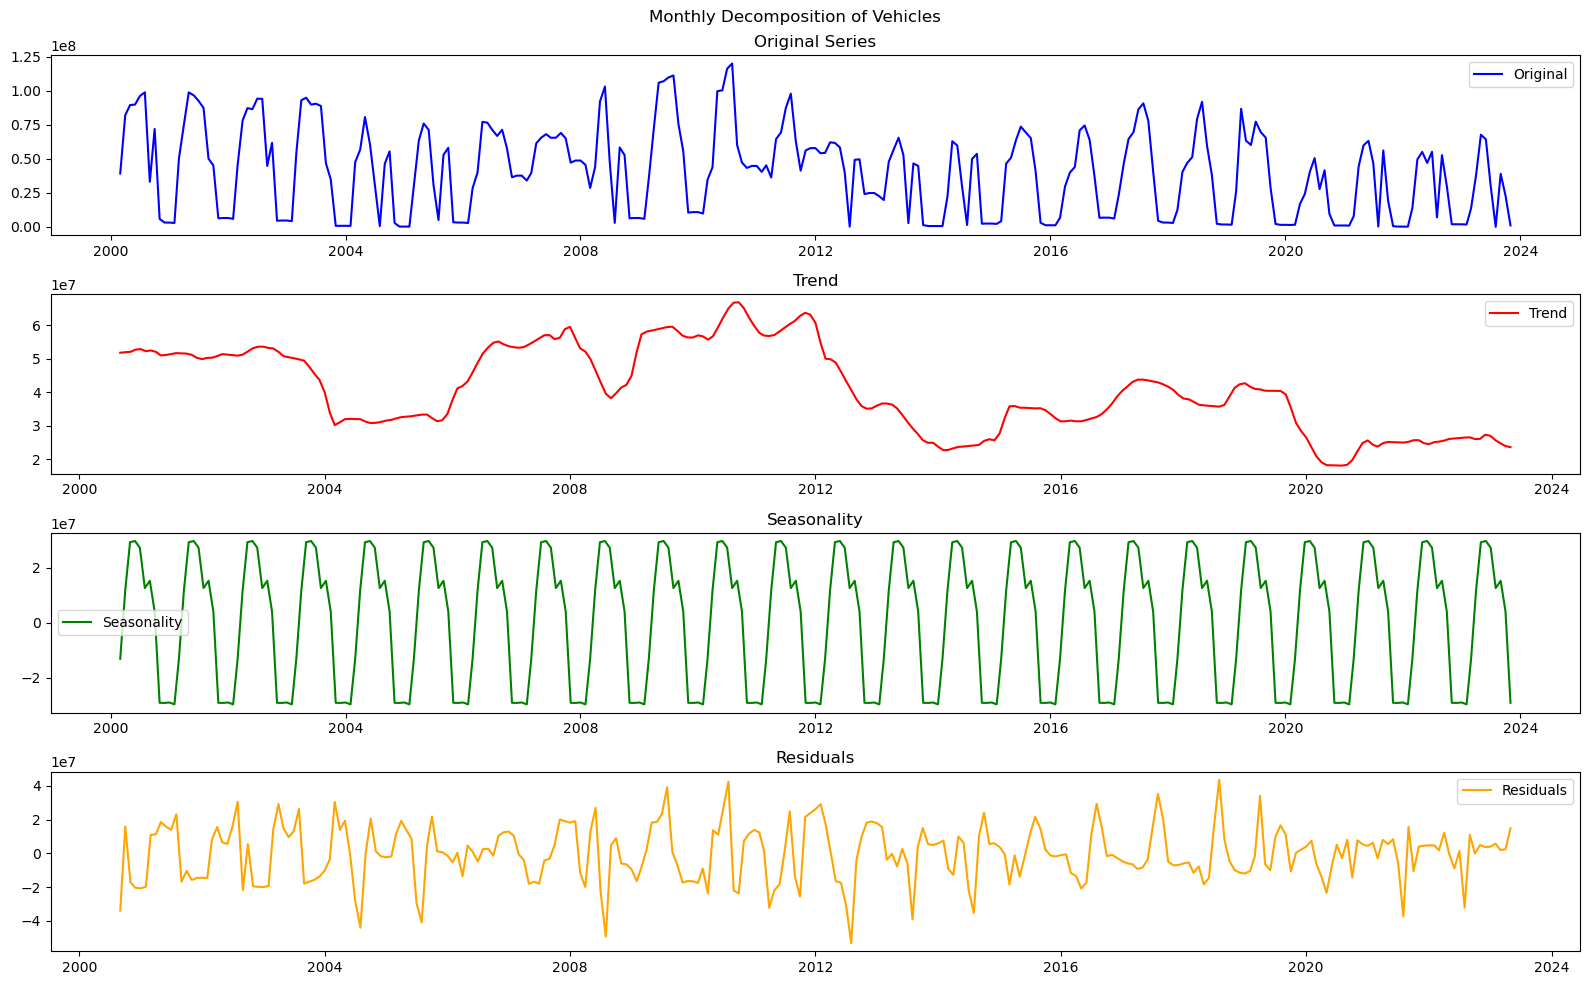

In [234]:
# Decompose the monthly data for 'all_motor_vehicles'
decompose_series(monthly_data['all_motor_vehicles'], period=12, title='Monthly Decomposition of Vehicles')

**Notes**
- We can see there is a pattern in the data with the highest values being around the summer time and the lowest values being around the winter seasons.
- 2020 onwards, shows a significant decrease in traffic volume. This is likely due to the COVID-19 pandemic.
- The data is not normalised, with some missing valies and outliers. 

In [235]:
monthly_data.shape

(285, 2)

In [236]:
monthly_data.head()

,all_motor_vehicles,all_motor_vehicles_millions
timestamp,,
2000-03-01,39257164.0,39.257164
2000-04-01,82032700.0,82.032700
2000-05-01,89490291.0,89.490291
2000-06-01,89880510.0,89.880510
2000-07-01,96094604.0,96.094604


In [237]:
monthly_data.to_csv("../data/monthly_data.csv")